## Trading System Classes

In [37]:
class Trader():
    def __init__(self, stock_exchange, capital):
        self.initial_capital = capital
        self.cash = capital
        self.portfolio = {}
        self.exchange = stock_exchange
        self.transaction_fees = 0.002
        
    def buy(self, counter, size_to_buy):
        # checks if counter even exists
        if counter in self.exchange.get_available_counters():
            # enough cash?
            if self.exchange.get_price(counter) * size_to_buy <= self.cash:
                self.cash -= (self.exchange.get_price(counter) * size_to_buy * (1+self.transaction_fees))
                if counter not in self.portfolio.keys():
                    self.portfolio[counter] = size_to_buy
                else:
                    self.portfolio[counter] += size_to_buy
            else:
                raise ValueError('Not enough money')
            pass


    def sell(self, counter, size_to_sell):
        # checks if shares exists in trader's portfolio
        if counter in self.portfolio.keys():
            # enough shares?
            if size_to_sell > 0:
                if self.portfolio[counter] >= size_to_sell:
                    #print("Cash before:")
                    #print(self.cash)
                    self.portfolio[counter] -= size_to_sell
                    #print("Cash gotten:")
                    #print(self.exchange.get_price(counter) * size_to_sell * (1-self.transaction_fees))
                    self.cash += (self.exchange.get_price(counter) * size_to_sell * (1-self.transaction_fees))
                    #print("Cash now:")
                    #print(self.cash)
                else:
                    raise ValueError('Not enough shares to sell')
    def get_portfolio_value(self):
        value = self.cash;
        for i in self.portfolio.keys():
            value = value + (self.portfolio[i] * self.exchange.get_price(i))
            #print('Date: ' + str(self.exchange.get_date()))
        return value
    
    def get_portfolio(self):
        return self.portfolio
    
    def get_max_stocks_purchasable(self, counter, funds):
        return math.floor(funds/((1+self.transaction_fees) * self.exchange.get_price(counter)))
    
    def get_cash(self):
        return self.cash
    
    def get_initial_capital(self):
        return self.initial_capital
    
    def get_profits(self):
        return self.get_portfolio_value() - self.get_initial_capital()
    
    @staticmethod
    def copy(trader):
        new_trader = Trader(trader.exchange, trader.get_initial_capital())
        new_trader.cash = trader.get_cash()
        
        if stock_symbol in trader.get_portfolio().keys():
            new_trader.portfolio = { stock_symbol : trader.get_portfolio()[stock_symbol]}
        else:
            new_trader.portfolio = {}
        new_trader.transaction_fees = 0.00175#0.002
        return new_trader
            
class Stock_Exchange():
    def __init__(self, counters):
        self.available_counters = counters # takes a list, ['aig', 'bac', 'c', 'googl_v3', 'gs', 'jpm']
        self.data = {}
        self.date = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d").date()
        self.last_date = datetime.datetime.strptime('2020-01-01', "%Y-%m-%d").date()
        for i in self.available_counters:
            data = pd.read_csv('data/' + i + '.csv')
            data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
            self.data[i] = data
            if(self.date < self.data[i]["Date"][0]):
                self.date = self.data[i]["Date"][0]
                
            if(self.last_date > self.data[i]["Date"].iloc[-1]):
                self.last_date = self.data[i]["Date"].iloc[-1]
        
        self.first_date = self.date
        
    def get_available_counters(self):
        return self.available_counters
    
    def get_price(self, counter):
        if(counter in self.available_counters):
            #print(self.data)
            val = self.data[counter].loc[self.data[counter]['Date'] == self.date]['Close']
            return list(val)[0]
        else:
            raise ValueError('Counter does not exist in exchange')
            
    def set_date(self, date, date_format):
        date = datetime.datetime.strptime(date, date_format).date()
        self.date = date
        
    def set_date(self, date):
        self.date = date
    
    def get_date(self):
        return self.date
            
    def next_day(self):
        self.date = self.date + datetime.timedelta(days=1)
        repeat = True
        while repeat:
            repeat = False
            '''for i in self.available_counters:
                if not (self.data[i]['Date'] == self.date).any():
                    #print(self.date)
                    #print('is a weekend')
                    self.date = self.date + datetime.timedelta(days=1)
                    repeat = True
                    break
            '''
            if self.date.weekday() >= 5:
                self.date = self.date + datetime.timedelta(days=1)
                repeat = True
    def get_last_date(self):
        return self.last_date
    
    def get_first_date(self):
        return self.first_date
    
    def reset(self):
        self.date = self.first_date
    
    def fast_forward(self):
        self.date = self.last_date

In [38]:
import pandas as pd
import numpy as np
import datetime
import math
import copy
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

In [54]:
risk_levels = [-1, -0.5, -0.2, 0, 0.2, 0.5, 1]

ACTION_LONG = 0
ACTION_CLOSE = 1

'''
PARAMETERS TO CHANGE
'''
start_price_indexes = [155]#[25, 725, 1425] # this should be (25 + start_state_num from the risk_q_learning file)
duration_for_each = 105 # this should be the same as the duration in risk_q_learning
comparison_offset = 25 # this should be the same as window_size in risk_adaptive_trading_data_generation
stock_symbol = 'bac'
capital = 10000
''''''

trading_patterns_dir = './trading_patterns/'
training_data_dir = './training_data/'
trading_patterns = []
trading_patterns_dict = {}

dates = []
populated_dates = False
for level in risk_levels:    
    trading_patterns_dict[level] = {}
    
    for start_price_index in start_price_indexes:
        actions_data = pd.read_csv(trading_patterns_dir + stock_symbol + '_' + str(level) + '_' + str(start_price_index) + '_to_' + str(start_price_index + duration_for_each) + '.csv')
        actions_data['Date'] = actions_data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())

        for index, row in actions_data[start_price_index:start_price_index+duration_for_each].iterrows():
            trading_patterns_dict[level][row['Date']] = row['trading_action']
            if populated_dates is False:
                dates.append(row['Date'])
                
    populated_dates = True
exchange = Stock_Exchange([stock_symbol])
secondary_exchange = Stock_Exchange([stock_symbol])

In [55]:
# CHECK PROFITS OF EACH RISK LEVEL
for risk_level in risk_levels:
    gupta = Trader(exchange, capital)
    print('Risk Level: ' + str(risk_level))
    long_days = 0
    pattern_dates =  list(trading_patterns_dict[risk_level].keys())[comparison_offset:]
    for date in pattern_dates:
        exchange.set_date(date)
        action = trading_patterns_dict[risk_level][date]
        if action == ACTION_LONG:
            stocks_to_buy = gupta.get_max_stocks_purchasable(stock_symbol, gupta.get_cash())
            long_days += 1
            gupta.buy(stock_symbol, stocks_to_buy)
        elif action == ACTION_CLOSE:
            if stock_symbol in gupta.get_portfolio().keys():
                gupta.sell(stock_symbol, gupta.get_portfolio()[stock_symbol])
            
    print('Long percentage: ' + str(long_days/len(pattern_dates)))
    print(gupta.get_portfolio_value()- gupta.initial_capital)
    print(str(((gupta.get_portfolio_value()- gupta.initial_capital) / gupta.initial_capital) * 100) + '%')
    exchange.reset()

Risk Level: -1
Long percentage: 0.0
0
0.0%
Risk Level: -0.5
Long percentage: 0.7875
280.3858014439975
2.803858014439975%
Risk Level: -0.2
Long percentage: 0.8875
429.8880202599994
4.298880202599994%
Risk Level: 0
Long percentage: 0.675
722.9553548459953
7.229553548459953%
Risk Level: 0.2
Long percentage: 0.225
461.54723711999577
4.615472371199958%
Risk Level: 0.5
Long percentage: 0.9125
849.092309767997
8.49092309767997%
Risk Level: 1
Long percentage: 1.0
1756.3553670000001
17.56355367%


In [56]:
### find best model on this date
def find_best_model(dates):
    best_model = None
    best_profit = None
    for i in risk_levels:
            
        tmp_dict = {}
        tmp_dict['Date'] = dates
        tmp_dict['trading_action'] = []
        for day in dates:
            tmp_dict['trading_action'].append(trading_patterns_dict[i][day])
        
        profit = calculate_profit(pd.DataFrame(tmp_dict))
        if best_model is None or profit > best_profit:
            best_profit = profit
            best_model = i
    return best_model
            
            
def calculate_profit(a_trading_pattern):
    mock_trader = Trader(secondary_exchange, capital)
    trade(a_trading_pattern, mock_trader)
    return mock_trader.get_portfolio_value() - mock_trader.get_initial_capital()
    

def trade(a_trading_pattern, mock_trader):
    for index, row in a_trading_pattern.iterrows():
        secondary_exchange.set_date(row['Date'])
        if row['trading_action'] == ACTION_LONG:
            stocks_to_buy = mock_trader.get_max_stocks_purchasable(stock_symbol, mock_trader.get_cash())
            mock_trader.buy(stock_symbol, stocks_to_buy)
        elif row['trading_action'] == ACTION_CLOSE:
            if stock_symbol in mock_trader.get_portfolio().keys():
                mock_trader.sell(stock_symbol, mock_trader.get_portfolio()[stock_symbol])

## Gupta's Risk Adaptive

In [57]:
'''exchange.reset()
gupta = Trader(exchange, capital)
gupta_window = 21
for i in range(comparison_offset,len(dates)):
    exchange.set_date(dates[i])
    best_risk_model = find_best_model(dates[i:i-gupta_window])
    action = trading_patterns_dict[best_risk_model][dates[i]]
    if action == ACTION_LONG:
            stocks_to_buy = gupta.get_max_stocks_purchasable(stock_symbol, gupta.get_cash())
            gupta.buy(stock_symbol, stocks_to_buy)
    elif action == ACTION_CLOSE:
        if stock_symbol in gupta.get_portfolio().keys():
            gupta.sell(stock_symbol, gupta.get_portfolio()[stock_symbol])
    print(str(i) + '/' + str(len(dates)))
print('Profit:' + str(gupta.get_portfolio_value()-gupta.get_initial_capital()))'''

"exchange.reset()\ngupta = Trader(exchange, capital)\ngupta_window = 21\nfor i in range(comparison_offset,len(dates)):\n    exchange.set_date(dates[i])\n    best_risk_model = find_best_model(dates[i:i-gupta_window])\n    action = trading_patterns_dict[best_risk_model][dates[i]]\n    if action == ACTION_LONG:\n            stocks_to_buy = gupta.get_max_stocks_purchasable(stock_symbol, gupta.get_cash())\n            gupta.buy(stock_symbol, stocks_to_buy)\n    elif action == ACTION_CLOSE:\n        if stock_symbol in gupta.get_portfolio().keys():\n            gupta.sell(stock_symbol, gupta.get_portfolio()[stock_symbol])\n    print(str(i) + '/' + str(len(dates)))\nprint('Profit:' + str(gupta.get_portfolio_value()-gupta.get_initial_capital()))"

## Mine

In [58]:
def get_processed_data(technical_indicated_file):
    std_span = 10
    # Data reading and preprocessing
    data =  pd.read_csv(technical_indicated_file)
    data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
    small_data = data
    x = small_data['Date']

    # Calculating std (sigma)
    std = pd.DataFrame()
    std['Date'] = small_data['Date']
    std['Rolling-STD'] = small_data["EMA-12-Close"].rolling(std_span).std()
    
    # PCT_CHANGE
    small_data['Pct_Change'] = small_data['EMA-12-Close'].pct_change()
    small_data['Abs_Pct_Change'] = abs(small_data['EMA-12-Close'].pct_change())
    small_data['Pct_Change_Vol'] = small_data['EMA-12-Volume'].pct_change()

    """
    Calculating volatility
    """
    crashes_k = pd.DataFrame()
    crashes_k["Date"] = small_data["Date"]
    crashes_k["crashes_k"] = small_data['neg_and_above_threshold'] * 1


    """ 
    Using PPO for Timing
    """
    # neg_k = 1 when trigger goes on top of PPO line (Red)
    # pos_k = 1 when trigger goes below PPO line (Green)

    d = (small_data["PPO"] - small_data["PPO-EMA-Trigger"])

    # PPO Buy and Sell Signals
    ppo_above = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_below = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_buy_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_sell_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))


    d = (small_data["PPO"] - small_data["PPO-EMA-Trigger"])
    for i in range(1, len(d) - 1):
        if d[i] * d[i - 1] < 0.:
            # crossover at i
            if(d[i] > 0.):
                ppo_above[i] = small_data.loc[i, "PPO-EMA-Trigger"]
                ppo_buy_signals[i] = small_data.loc[i, "Date"]
            else:
                ppo_below[i] = small_data.loc[i, "PPO-EMA-Trigger"]
                ppo_sell_signals[i] = small_data.loc[i, "Date"]

    #ppo_buy_signals.to_csv(folder + counter + "-ppo-buy.csv", index=False)
    #ppo_sell_signals.to_csv(folder + counter + "-ppo-sell.csv", index=False)


    # Caclulating ppo_k
    ppo_k = pd.DataFrame()

    # Populating std
    ppo_k['std'] = std['Rolling-STD']

    # Filling pos_k and neg_k with 1
    ppo_k["Date"] = small_data["Date"]
    ppo_k["pos_k"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["pos_k"].loc[ppo_k["Date"] == ppo_buy_signals] = 1

    ppo_k["neg_k"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["neg_k"].loc[ppo_k["Date"] == ppo_sell_signals] = 1
    assert(all(std["Date"] == ppo_k["Date"]))

    # Filling ppo_k dataframe with t to help speed up calculation during half-life
    # Init t as 0 for dates where ppo signals
    ppo_k["pos_k_t"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["pos_k_t"].loc[ppo_k["pos_k"] == 1] = 0

    ppo_k["neg_k_t"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["neg_k_t"].loc[ppo_k["neg_k"] == 1] = 0

    # Identify first pos_k and first neg_k
    first_pos_k_index = ppo_k['pos_k'].idxmax()
    first_neg_k_index = ppo_k['neg_k'].idxmax()

    # Populating ppo t values 
    tmp = ppo_k.copy()
    i = 0
    while ppo_k["pos_k_t"][first_pos_k_index:].isnull().values.any() or ppo_k["neg_k_t"][first_neg_k_index:].isnull().values.any():
        i+=1
        tmp = tmp.shift()
        ppo_k["pos_k_t"].loc[(tmp["pos_k"] == 1) & (ppo_k["pos_k_t"].isnull())] = i
        ppo_k["neg_k_t"].loc[(tmp["neg_k"] == 1) & (ppo_k["neg_k_t"].isnull())] = i


    """
    Using RSI for Timing
    """
    # neg_k = 1 when above 70 (Overbought)
    # pos_k = 1 when above 30 (Oversold)
    overbought = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    oversold = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    rsi_buy_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    rsi_sell_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))

    d_overbought = (70 - small_data["RSI"])
    for i in range(1, len(d_overbought) - 1):
        '''if d_overbought[i] * d_overbought[i - 1] < 0.:
                # crossover at i
                if d_overbought[i] < 0.:
                    rsi_sell_signals[i] = small_data.loc[i, "Date"]
                    overbought[i] = 70 #small_data.loc[i, "RSI"]'''
        if(d_overbought[i] < 0):
            rsi_sell_signals[i] = small_data.loc[i, "Date"]




    d_oversold = (30 - small_data["RSI"])
    for i in range(1, len(d_oversold) - 1):
        '''if d_oversold[i] * d_oversold[i - 1] < 0.:
                # crossover at i
                if d_oversold[i] > 0.:
                    rsi_buy_signals[i] = small_data.loc[i, "Date"]
                    oversold[i] = 30 #small_data.loc[i, "RSI"]'''
        if(d_oversold[i] > 0):
            rsi_buy_signals[i] = small_data.loc[i, "Date"]



    # Caclulating rsi_k
    rsi_k = pd.DataFrame()

    # Populating std
    rsi_k['std'] = std['Rolling-STD']

    # Filling pos_k and neg_k with 1
    rsi_k["Date"] = small_data["Date"]
    rsi_k["pos_k"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["pos_k"].loc[rsi_k["Date"] == rsi_buy_signals] = 1

    rsi_k["neg_k"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["neg_k"].loc[rsi_k["Date"] == rsi_sell_signals] = 1
    assert(all(std["Date"] == rsi_k["Date"]))


    # Filling rsi_k dataframe with t to help speed up calculation during half-life
    # Init t as 0 for dates where rsi signals
    rsi_k["pos_k_t"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["pos_k_t"].loc[rsi_k["pos_k"] == 1] = 0

    rsi_k["neg_k_t"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["neg_k_t"].loc[rsi_k["neg_k"] == 1] = 0

    # Identify first pos_k and first neg_k
    first_pos_k_index = rsi_k['pos_k'].idxmax()
    first_neg_k_index = rsi_k['neg_k'].idxmax()

    # Populating rsi t values 
    tmp = rsi_k.copy()
    i = 0
    while rsi_k["pos_k_t"][first_pos_k_index:].isnull().values.any() or rsi_k["neg_k_t"][first_neg_k_index:].isnull().values.any():
        i+=1
        tmp = tmp.shift()
        rsi_k["pos_k_t"].loc[(tmp["pos_k"] == 1) & (rsi_k["pos_k_t"].isnull())] = i
        rsi_k["neg_k_t"].loc[(tmp["neg_k"] == 1) & (rsi_k["neg_k_t"].isnull())] = i
    
    return ppo_k, rsi_k, crashes_k, small_data, ppo_buy_signals, ppo_sell_signals, rsi_buy_signals, rsi_sell_signals

def get_combined_k(decay_alpha_ppo, decay_alpha_rsi, ppo_k, rsi_k, technical_data, crashes_k):
    """
    Generate combined pos_k and neg_k based on given decay_alpha
    """
    
    assert(len(ppo_k) == len(rsi_k) and len(technical_data) == len(crashes_k) and len(technical_data == len(ppo_k)))
    
    # Decay ppo_k using half-life 
    ppo_k["pos_k_hl"] = ppo_k["pos_k"]
    ppo_k["neg_k_hl"] = ppo_k["neg_k"]

    tmp = (-1 * decay_alpha_ppo * technical_data['Abs_Pct_Change'])
    
    ppo_k["pos_k_hl"] = (math.e ** (tmp * ppo_k["pos_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    ppo_k["neg_k_hl"] = (math.e ** (tmp * ppo_k["neg_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    
    '''ppo_k["pos_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_ppo * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * ppo_k["pos_k_t"])) 
    ppo_k["neg_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_ppo * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * ppo_k["neg_k_t"]))
    '''
    # Decay rsi_k using half-life 
    rsi_k["pos_k_hl"] = rsi_k["pos_k"]
    rsi_k["neg_k_hl"] = rsi_k["neg_k"]
    
    tmp = (-1 * decay_alpha_rsi * technical_data['Abs_Pct_Change'])

    rsi_k["pos_k_hl"] = (math.e ** (tmp * rsi_k["pos_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    rsi_k["neg_k_hl"] = (math.e ** (tmp * rsi_k["neg_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    
    '''rsi_k["pos_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_rsi * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * rsi_k["pos_k_t"])) 
    rsi_k["neg_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_rsi * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * rsi_k["neg_k_t"]))
    '''
    #print(rsi_k["pos_k_hl"])
    #rsi_k.to_csv(folder + counter + "-rsi.csv")
    #ppo_k.to_csv(folder + counter + "-ppo.csv")

    # Combining PPO_K and RSI_K
    assert(all(ppo_k["Date"] == rsi_k["Date"]) and all(ppo_k["Date"] == technical_data["Date"]) and all(crashes_k["Date"] == ppo_k["Date"]))
    
    combined_k = pd.DataFrame()
    combined_k["Date"] = technical_data["Date"]
    combined_k["pos_k_hl"] = ppo_k["pos_k_hl"].fillna(0) * rsi_k["pos_k_hl"].fillna(0)
    combined_k["neg_k_hl"] = pow(ppo_k["neg_k_hl"].fillna(0) * rsi_k["neg_k_hl"].fillna(0), 1-crashes_k["crashes_k"])
    #combined_k["neg_k_hl"] = ppo_k["neg_k_hl"].fillna(0) * rsi_k["neg_k_hl"].fillna(0)


    # Using ADX & DMI
    # Irrespective of whether the trader takes a long or short position, 
    # the ADX should be over 25 when the crossover occurs to confirm the trend’s strength. 
    combined_k["pos_k_hl_copy"] = combined_k["pos_k_hl"]
    combined_k["neg_k_hl_copy"] = combined_k["neg_k_hl"]

    assert(all(combined_k["Date"]==technical_data["Date"]))

    
    '''combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["neg_k_hl_copy"] * 1.0
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 30) & (technical_data["ADX"] < 40)] = combined_k["neg_k_hl_copy"] * 0.5
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 20) & (technical_data["ADX"] < 30)] = combined_k["neg_k_hl_copy"] * 0.25
    
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["pos_k_hl_copy"] * 1.0
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 30) & (technical_data["ADX"] < 40)] = combined_k["pos_k_hl_copy"] * 0.5
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 20) & (technical_data["ADX"] < 30)] = combined_k["pos_k_hl_copy"] * 0.25
    '''
    
    
    
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 20)] = combined_k["neg_k_hl"] * 0.25
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 30)] = combined_k["neg_k_hl"] * 0.5
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["neg_k_hl"] * 1.0
    
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 20)] = combined_k["pos_k_hl"] * 0.25
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 30)] = combined_k["pos_k_hl"] * 0.5
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["pos_k_hl"] * 1.0
    
    # Make it mutually exlusive
    combined_k["neg_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] > 20)] = 0
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] < technical_data["NEG_DI14"]) & (technical_data["ADX"] > 20)] = 0

    # Trend not strong enough
    combined_k["neg_k_hl_copy"].loc[(technical_data["ADX"] < 20)] = 0
    combined_k["pos_k_hl_copy"].loc[(technical_data["ADX"] < 20)] = 0

    # combined_k.to_csv(folder + counter + "-combined.csv", index=False)
    return combined_k

In [59]:
def closest_k(k):
    closest_risk = None
    closest_distance = None
    for risk_level in risk_levels:
        distance = abs(k-risk_level)
        if closest_risk is None or distance < closest_distance:
            closest_distance = distance
            closest_risk = risk_level
    return closest_risk

def to_action(row):
    date = row['Date']
    risk_level = row['k']
    tmp_pattern = trading_patterns_dict[risk_level]
    return tmp_pattern[date]
    #return tmp_pattern.loc[tmp_pattern['Date'] == date]['trading_action'].values[0]

In [60]:
exchange.reset()
jingyang = Trader(exchange, capital)
folder = "./temp/"
ppo_k, rsi_k, crashes_k, technical_data, tmp_ppo_buy_dates, tmp_ppo_sell_dates, tmp_rsi_buy_dates, tmp_rsi_sell_dates = get_processed_data(folder+stock_symbol+'-technical-indicated.csv')

tmp_start_date = dates[comparison_offset]
tmp_end_date = dates[-1]

start_date_index = technical_data.index[technical_data['Date'] == tmp_start_date].tolist()[0] 
end_date_index = technical_data.index[technical_data['Date'] == tmp_end_date].tolist()[0] 

c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [61]:
#PPO Trader

ppo_buy_dates = pd.DataFrame(tmp_ppo_buy_dates[start_date_index:end_date_index+1])
ppo_sell_dates = pd.DataFrame(tmp_ppo_sell_dates[start_date_index:end_date_index+1])

assert(len(ppo_buy_dates) == len(dates) - comparison_offset)
assert(len(ppo_sell_dates) == len(dates) - comparison_offset)

ppo_buy_dates.columns = ['Date']
ppo_sell_dates.columns = ['Date']

ppo_buy_dates.dropna(inplace=True)
ppo_sell_dates.dropna(inplace=True)

ppo_buy_dates = ppo_buy_dates.reset_index(drop=True)
ppo_sell_dates = ppo_sell_dates.reset_index(drop=True)


exchange.reset()
ppo_trader = Trader(exchange, capital)


sell_index = 0
for idx, row in ppo_buy_dates.iterrows():
    exchange.set_date(row['Date'])
    qty_to_buy = ppo_trader.get_max_stocks_purchasable(stock_symbol, ppo_trader.get_cash())
    #print('Buying ' + str(qty_to_buy) + ' on ' + str(row['Date']) + ' for ' + str(exchange.get_price(stock_symbol)))
    ppo_trader.buy(stock_symbol, qty_to_buy)
    
    while(True):
        if sell_index >= ppo_sell_dates.shape[0]:
            break
        assert(row['Date']!=ppo_sell_dates.loc[sell_index]['Date'])
        sell_date = ppo_sell_dates.loc[sell_index]['Date']
        
        # If sell date is later than the next buy date
        if idx+1<ppo_buy_dates.shape[0] and sell_date > ppo_buy_dates.loc[idx+1]['Date']:
            break
        
        # If sell date is earlier than the next buy date
        if idx+1==ppo_buy_dates.shape[0] or sell_date < ppo_buy_dates.loc[idx+1]['Date']:
            # If sell date is later than today
            if sell_date > row['Date']:
                exchange.set_date(sell_date)
                qty_on_hand = 0
                if(stock_symbol in ppo_trader.get_portfolio().keys()):
                    qty_on_hand = ppo_trader.get_portfolio()[stock_symbol]
                    
                qty_to_sell = qty_on_hand
                #print('Selling ' + str(qty_to_sell) + ' on ' + str(sell_date) + ' for ' + str(exchange.get_price(stock_symbol)))
                ppo_trader.sell(stock_symbol, qty_to_sell)
                sell_index+=1 
                break
            # If sell date is earlier than today
            if sell_date < row['Date']:
                sell_index+=1

#fast forward
exchange.set_date(tmp_end_date)
print(ppo_trader.get_portfolio_value()-ppo_trader.get_initial_capital())
print(str(((ppo_trader.get_portfolio_value()- ppo_trader.initial_capital) / ppo_trader.initial_capital) * 100) + '%')

697.6751120860008
6.976751120860008%


In [62]:
# RSI Trader

rsi_buy_dates = pd.DataFrame(tmp_rsi_buy_dates[start_date_index:end_date_index+1])
rsi_sell_dates = pd.DataFrame(tmp_rsi_sell_dates[start_date_index:end_date_index+1])

assert(len(rsi_buy_dates) == len(dates) - comparison_offset)
assert(len(rsi_sell_dates) == len(dates) - comparison_offset)

rsi_buy_dates.columns = ['Date']
rsi_sell_dates.columns = ['Date']

rsi_buy_dates.dropna(inplace=True)
rsi_sell_dates.dropna(inplace=True)

rsi_buy_dates = rsi_buy_dates.reset_index(drop=True)
rsi_sell_dates = rsi_sell_dates.reset_index(drop=True)


exchange.reset()
rsi_trader = Trader(exchange, capital)

sell_index = 0
for idx, row in rsi_buy_dates.iterrows():
    exchange.set_date(row['Date'])
    qty_to_buy = rsi_trader.get_max_stocks_purchasable(stock_symbol, rsi_trader.get_cash())
    #print('Buying ' + str(qty_to_buy) + ' on ' + str(row['Date']) + ' for ' + str(exchange.get_price(stock_symbol)))
    rsi_trader.buy(stock_symbol, qty_to_buy)
    
    while(True):
        if sell_index >= rsi_sell_dates.shape[0]:
            break
        assert(row['Date']!=rsi_sell_dates.loc[sell_index]['Date'])
        sell_date = rsi_sell_dates.loc[sell_index]['Date']
        
        # If sell date is later than the next buy date
        if idx+1<rsi_buy_dates.shape[0] and sell_date > rsi_buy_dates.loc[idx+1]['Date']:
            break
        
        # If sell date is earlier than the next buy date
        if idx+1==rsi_buy_dates.shape[0] or sell_date < rsi_buy_dates.loc[idx+1]['Date']:
            # If sell date is later than today
            if sell_date > row['Date']:
                exchange.set_date(sell_date)
                qty_on_hand = 0
                if(stock_symbol in rsi_trader.get_portfolio().keys()):
                    qty_on_hand = rsi_trader.get_portfolio()[stock_symbol]
                    
                qty_to_sell = qty_on_hand
                #print('Selling ' + str(qty_to_sell) + ' on ' + str(sell_date) + ' for ' + str(exchange.get_price(stock_symbol)))
                rsi_trader.sell(stock_symbol, qty_to_sell)
                sell_index+=1 
                break
            # If sell date is earlier than today
            if sell_date < row['Date']:
                sell_index+=1

#fast forward
exchange.set_date(tmp_end_date)
print(rsi_trader.get_portfolio_value()-rsi_trader.get_initial_capital())
print(str(((rsi_trader.get_portfolio_value()- rsi_trader.initial_capital) / rsi_trader.initial_capital) * 100) + '%')

0
0.0%


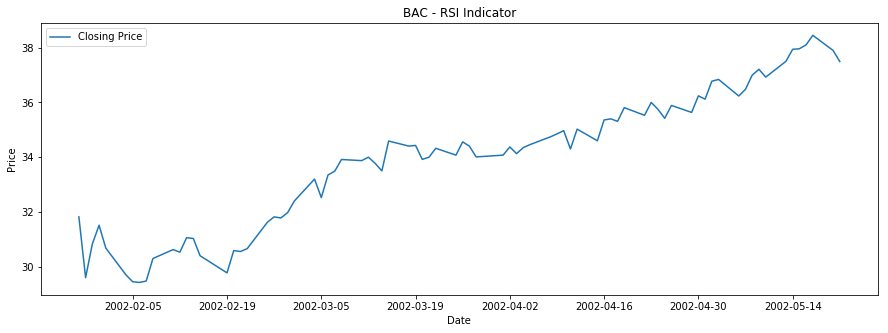

In [63]:
tmp = technical_data[start_date_index:end_date_index+1]
#tmp = tmp[2100:]
fig = plt.figure(figsize=(15,5))
plt.plot(tmp['Date'],tmp['Close'], figure=fig, label = "Closing Price")
plt.title(stock_symbol.upper() + ' - RSI Indicator')
for index, row in rsi_buy_dates.iterrows():
    first = True
    if row['Date'] > datetime.datetime.strptime('2007-03-01', "%Y-%m-%d").date():
        plt.axvline(row['Date'], color='g', linestyle='-', figure=fig, label= 'Buy Signal')
for index, row in rsi_sell_dates.iterrows():
    if row['Date'] > datetime.datetime.strptime('2007-03-01', "%Y-%m-%d").date():
        plt.axvline(row['Date'], color='r', linestyle='--', figure=fig, label = 'Sell Signal')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [64]:
# Buy & Hold Trader
exchange.reset()
buy_hold_trader = Trader(exchange, capital)
exchange.set_date(tmp_start_date)
qty_to_buy = buy_hold_trader.get_max_stocks_purchasable(stock_symbol, buy_hold_trader.get_cash())
buy_hold_trader.buy(stock_symbol, qty_to_buy)
exchange.set_date(tmp_end_date)
print(buy_hold_trader.get_portfolio_value()-buy_hold_trader.get_initial_capital())
print(str(((buy_hold_trader.get_portfolio_value()- buy_hold_trader.initial_capital) / buy_hold_trader.initial_capital) * 100) + '%')
exchange.reset()

1756.3553670000001
17.56355367%


In [216]:
# tmp = technical_data[start_date_index:end_date_index+1]
# x = tmp['Date'].values
# y_1_1 = tmp['Close']
# y_2_1 = tmp['Close']

# fig=plt.figure(figsize=(15,7))
# ax1 = plt.subplot(211)
# ax2 = plt.subplot(212)


# start = 1400
# end = 1600
# x = x[start:end]
# ax1.plot(x,y_1_1[start:end], label = 'Close')
# ax1.set_title(stock_symbol.upper() + ' - RSI Signals')
# for index, row in rsi_buy_dates.iterrows():
#     first = True
#     if row['Date'] > x[0] and  row['Date'] < x[-1]:
#         ax1.axvline(row['Date'], color='g', linestyle='-', label= 'Buy Signal')
#         #print(row['Date'])
# for index, row in rsi_sell_dates.iterrows():
#     if row['Date'] > x[0] and  row['Date'] < x[-1]:
#         ax1.axvline(row['Date'], color='r', linestyle='--', label = 'Sell Signal')
        
# ax1.set_ylabel('Price')
        
# ax2.plot(x,y_2_1[start:end])
# ax2.set_title(stock_symbol.upper() + ' - PPO Signals')
# for index, row in ppo_buy_dates.iterrows():
#     first = True
#     if row['Date'] > x[0] and  row['Date'] < x[-1]:
#         ax2.axvline(row['Date'], color='g', linestyle='-', label= 'Buy Signal')
#         #print(row['Date'])
# for index, row in ppo_sell_dates.iterrows():
#     if row['Date'] > x[0] and  row['Date'] < x[-1]:
#         ax2.axvline(row['Date'], color='r', linestyle='--', label = 'Sell Signal')
        
# ax2.set_ylabel('Price')
# ax2.set_xlabel('Date')

# handles, labels = ax1.get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

# handles, labels = ax2.get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# ax2.legend(by_label.values(), by_label.keys(), loc='upper right')

